# Предсказание удовлетворенности полетом

In [110]:
!pip install phik

  Obtaining dependency information for phik from https://files.pythonhosted.org/packages/86/a9/2e70ab81c9383c92d95d776a08fa6253529a5f018d02e2e78791195b1b71/phik-0.12.5-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/675.0 kB ? eta -:--:--
    --------------------------------------- 10.2/675.0 kB ? eta -:--:--
   - ------------------------------------- 30.7/675.0 kB 262.6 kB/s eta 0:00:03
   --- ----------------------------------- 61.4/675.0 kB 365.7 kB/s eta 0:00:02
   ---- ---------------------------------- 71.7/675.0 kB 393.8 kB/s eta 0:00:02
   ------ ------------------------------- 122.9/675.0 kB 554.9 kB/s eta 0:00:01
   ------------ ------------------------- 225.3/675.0 kB 811.5 kB/s eta 0:00:01
   ------------- ------------------------ 235.5/675.0 kB 722.1 kB/s eta 0:00:01
   ------------------- ------------------ 348.2/675.0 kB 941.3 kB/s eta 0:00:01
   ------------------- ------------------ 348.2/675.0 kB 941.3 kB/s eta 0:00:01
   -----------

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             classification_report,
                             confusion_matrix,
                             precision_recall_curve,
                            )
import catboost
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from phik import phik_matrix
RANDOM_STATE = 42

### Загрузка данных

In [2]:
data = pd.read_csv('data.csv')

In [3]:
pd.set_option("display.max_columns", None)

In [4]:
data = data.rename(columns={'Inflight wifi service':'Wifi', 
                     'Departure/Arrival time convenient':'Time convenient',
                     'Departure Delay in Minutes' : 'Dep delay',
                    'Arrival Delay in Minutes' : 'Arr delay',
                    })
data.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Wifi,Time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Dep delay,Arr delay,satisfaction
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,5,3,5,5,4,3,4,4,5,25,18.0,False
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,1,3,1,1,1,5,3,1,1,1,6.0,False
2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,5,5,5,5,4,3,4,4,5,0,0.0,True
3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,2,2,2,2,2,5,3,1,2,11,9.0,False
4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,4,5,5,3,3,4,4,3,3,0,0.0,True


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Gender                  129880 non-null  object 
 1   Customer Type           129880 non-null  object 
 2   Age                     129880 non-null  int64  
 3   Type of Travel          129880 non-null  object 
 4   Class                   129880 non-null  object 
 5   Flight Distance         129880 non-null  int64  
 6   Wifi                    129880 non-null  int64  
 7   Time convenient         129880 non-null  int64  
 8   Ease of Online booking  129880 non-null  int64  
 9   Gate location           129880 non-null  int64  
 10  Food and drink          129880 non-null  int64  
 11  Online boarding         129880 non-null  int64  
 12  Seat comfort            129880 non-null  int64  
 13  Inflight entertainment  129880 non-null  int64  
 14  On-board service    

### Предобработка данных

In [6]:
data.isna().sum()

Gender                      0
Customer Type               0
Age                         0
Type of Travel              0
Class                       0
Flight Distance             0
Wifi                        0
Time convenient             0
Ease of Online booking      0
Gate location               0
Food and drink              0
Online boarding             0
Seat comfort                0
Inflight entertainment      0
On-board service            0
Leg room service            0
Baggage handling            0
Checkin service             0
Cleanliness                 0
Dep delay                   0
Arr delay                 393
satisfaction                0
dtype: int64

In [7]:
data.duplicated().sum()

0

In [8]:
map_to_binary = {
    'Gender' : {'Male':0, 'Female':1},
    'Type of Travel' : {'Personal Travel':0, 'Business travel':1},
    'Customer Type' : {'Loyal Customer':0, 'disloyal Customer':1},
}
for i in map_to_binary.keys():
    data[i] = data[i].replace(map_to_binary[i])

In [9]:
enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
flight_class = enc.fit_transform(data[['Class']])
flight_class = pd.DataFrame(flight_class,
    columns=enc.get_feature_names_out(["Class"]),
    index=data.index)
data = pd.concat([data.drop(columns='Class'), flight_class], axis=1)

In [10]:
data['Arr delay'] = data['Arr delay'].fillna(0)

In [11]:
num_cols = data.select_dtypes(include=[np.number]).columns.tolist()
ord_cols = ['Wifi', 'Time convenient', 'Ease of Online booking', \
           'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', \
           'Inflight entertainment', 'On-board service', 'Leg room service', \
           'Baggage handling', 'Checkin service', 'Cleanliness']
numeric = ['Age', 'Flight Distance', 'Arr delay']

In [12]:
data.head()

,Gender,Customer Type,Age,Type of Travel,Flight Distance,Wifi,Time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Dep delay,Arr delay,satisfaction,Class_Business,Class_Eco,Class_Eco Plus
0,0,0,13,0,460,3,4,3,1,5,3,5,5,4,3,4,4,5,25,18.0,False,0.0,0.0,1.0
1,0,1,25,1,235,3,2,3,3,1,3,1,1,1,5,3,1,1,1,6.0,False,1.0,0.0,0.0
2,1,0,26,1,1142,2,2,2,2,5,5,5,5,4,3,4,4,5,0,0.0,True,1.0,0.0,0.0
3,1,0,25,1,562,2,5,5,5,2,2,2,2,2,5,3,1,2,11,9.0,False,1.0,0.0,0.0
4,0,0,61,1,214,3,3,3,3,4,5,5,3,3,4,4,3,3,0,0.0,True,1.0,0.0,0.0


In [13]:
data_new = data.copy()
data_new[ord_cols] = data_new[ord_cols].replace(0, np.nan)

## Исследовательский анализ данных

<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


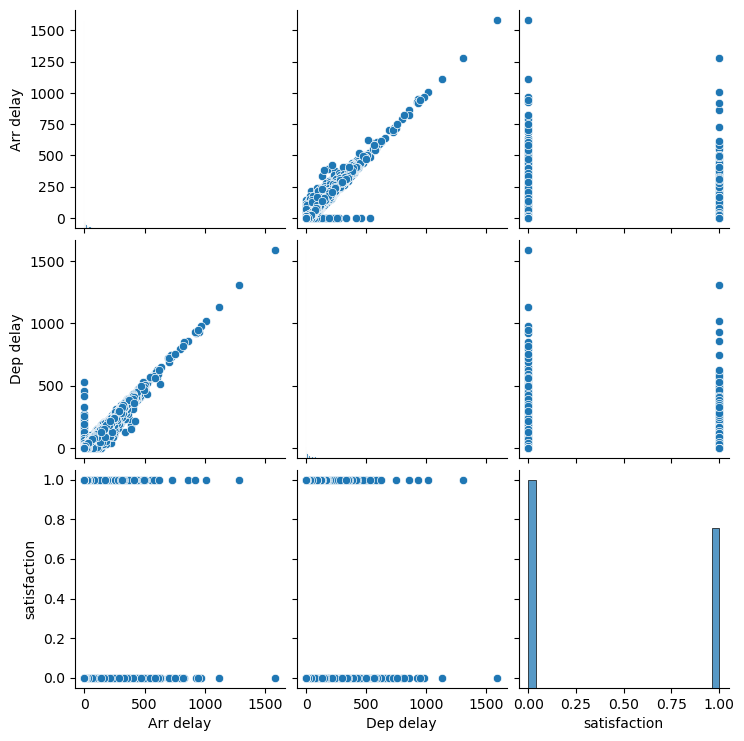

In [14]:
sns.pairplot(data[['Arr delay', 'Dep delay', 'satisfaction']])

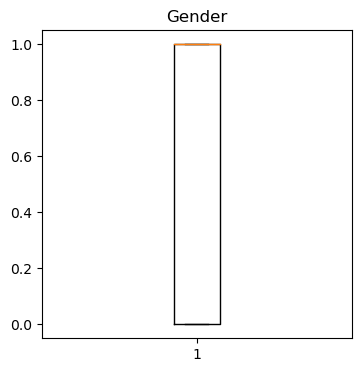

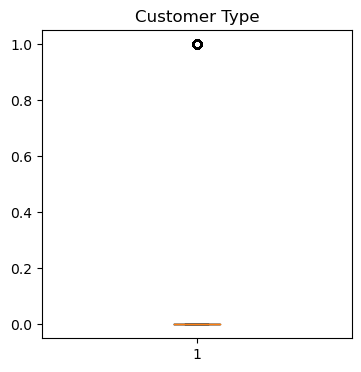

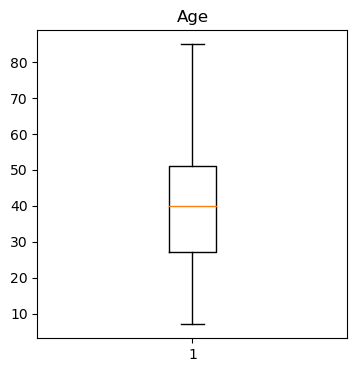

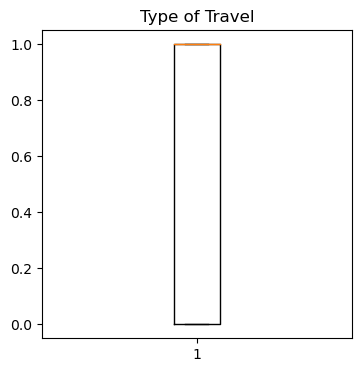

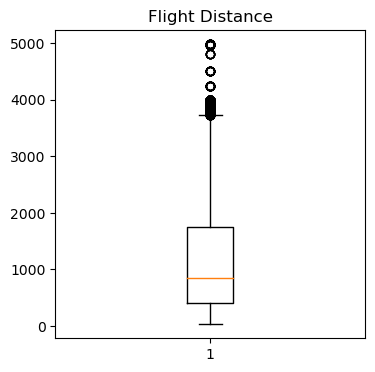

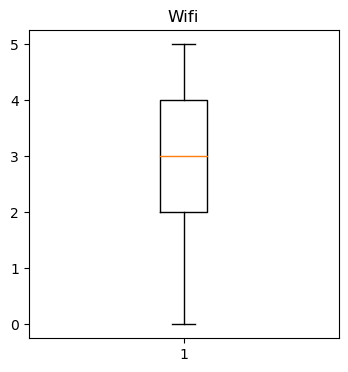

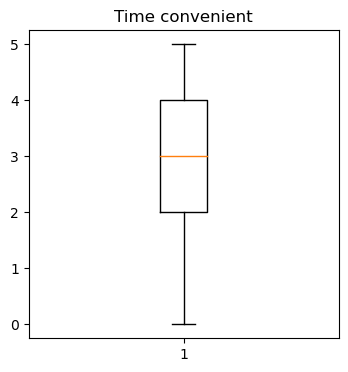

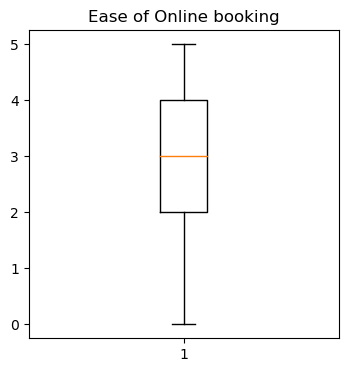

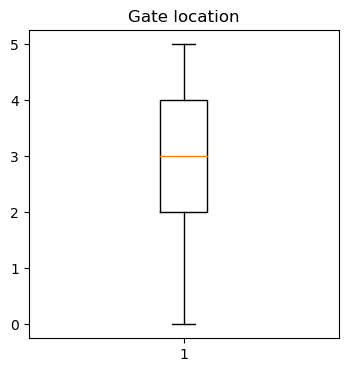

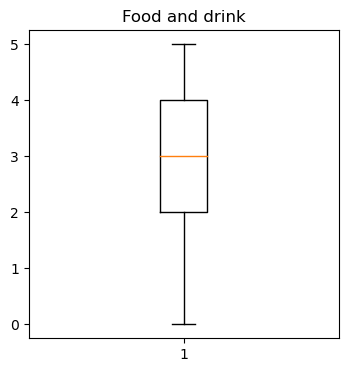

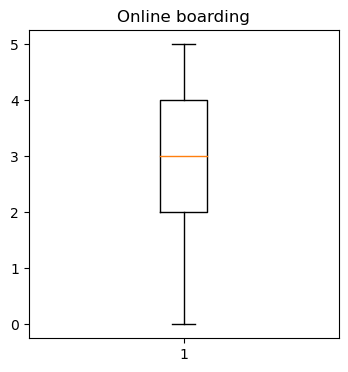

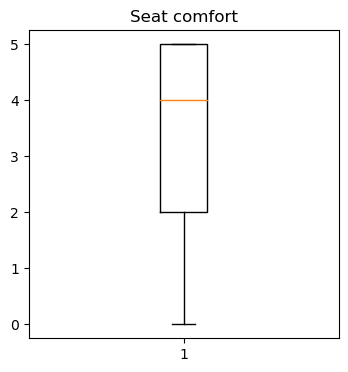

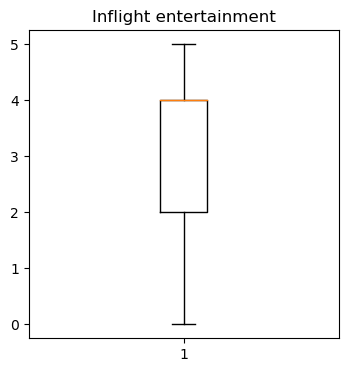

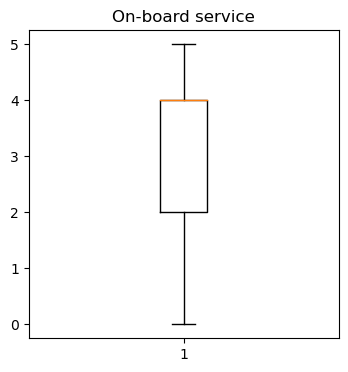

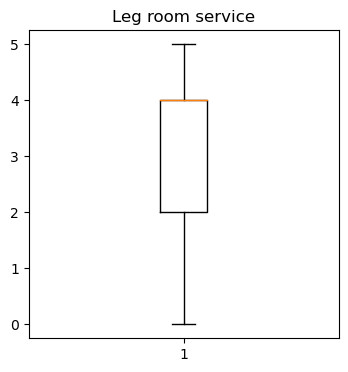

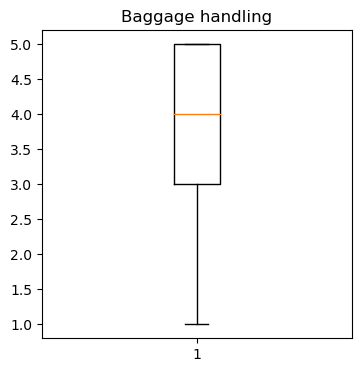

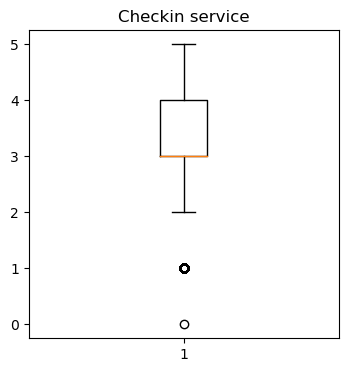

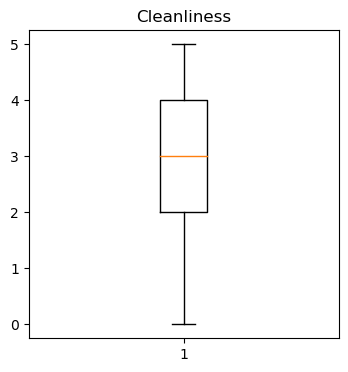

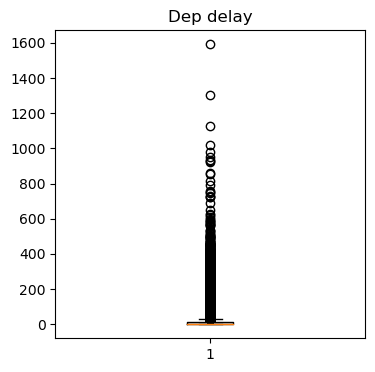

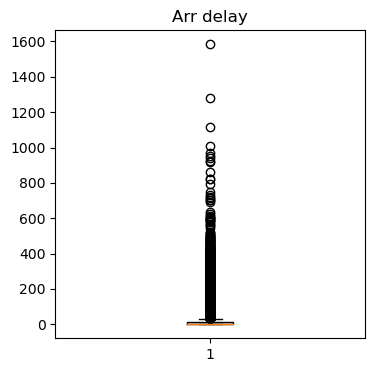

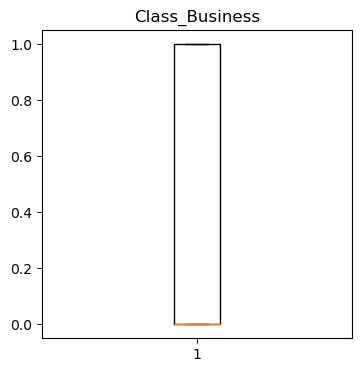

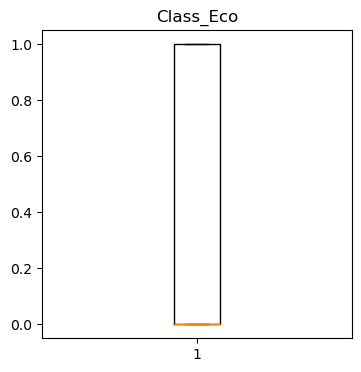

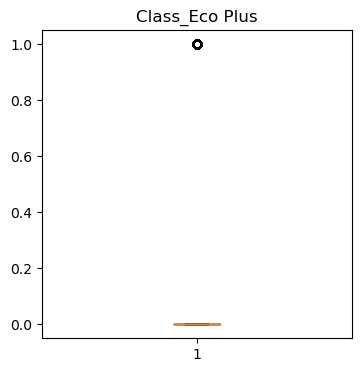

In [15]:
def get_numeric_boxplots(df, num):
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    for i in range(len(num_cols)):
        plt.figure(figsize=(4, 4))
        plt.boxplot(df[num_cols[i]])
        plt.title(num[i])
        plt.show()
get_numeric_boxplots(data, num_cols)

*Видно, что вбросов в целом нет*

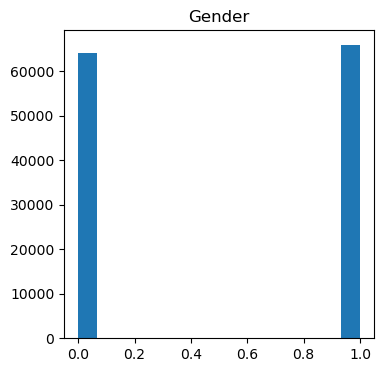

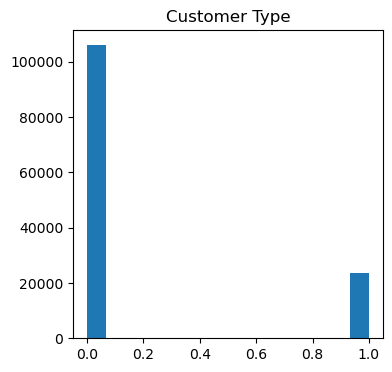

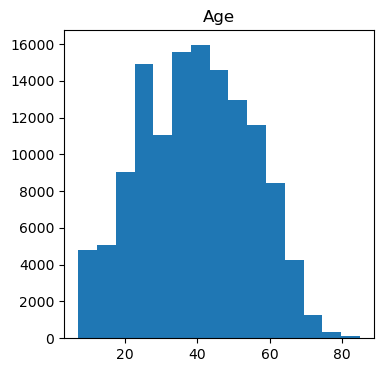

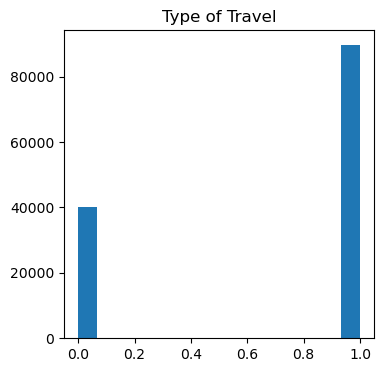

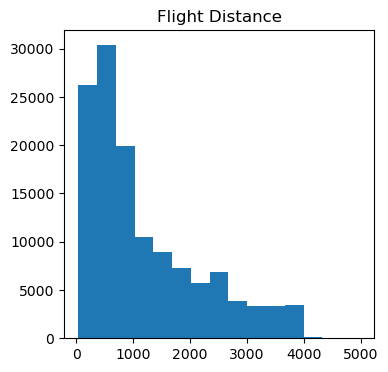

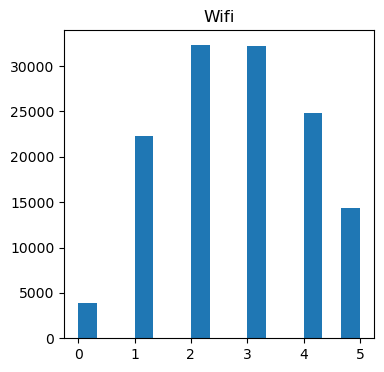

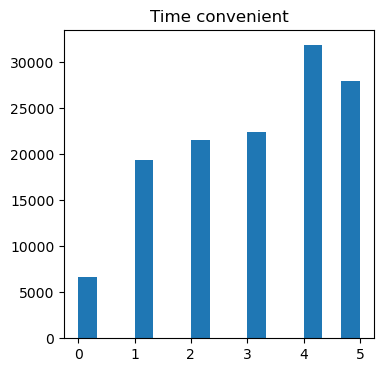

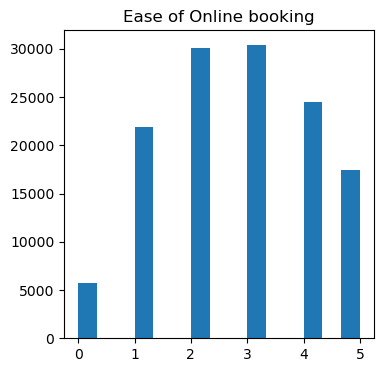

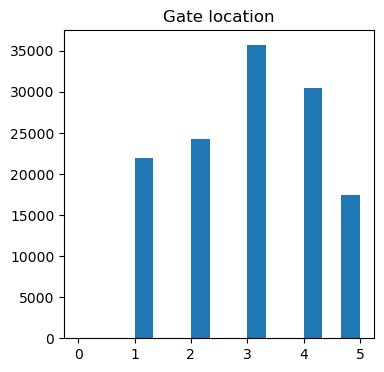

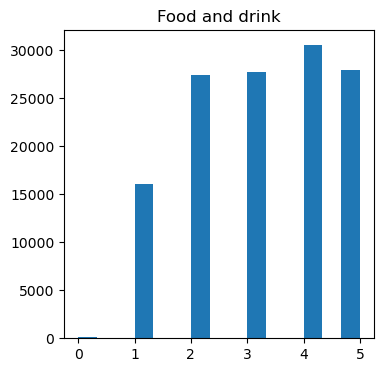

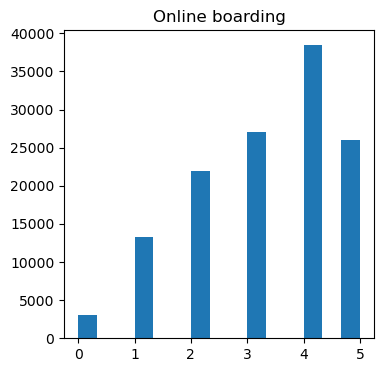

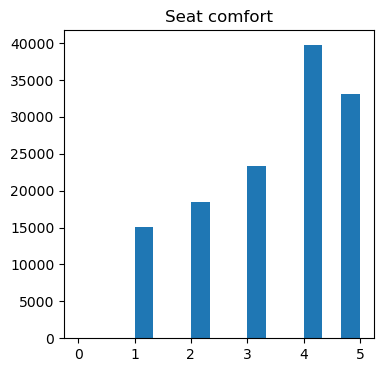

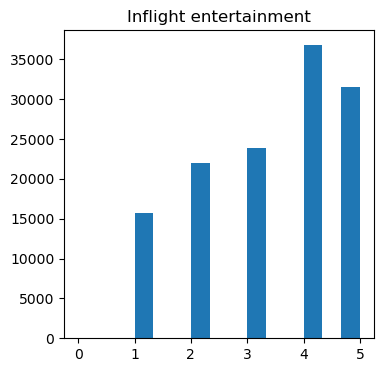

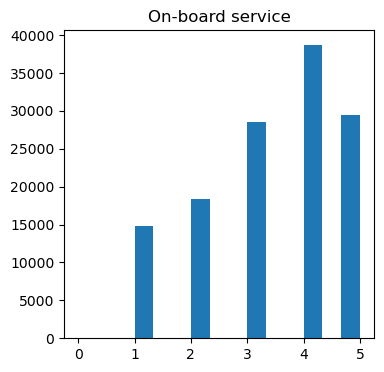

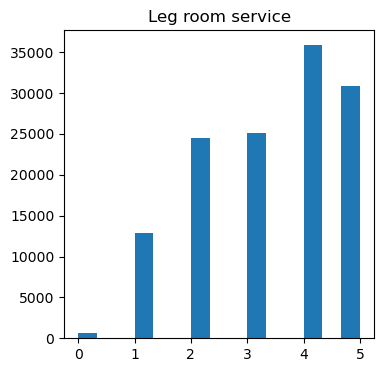

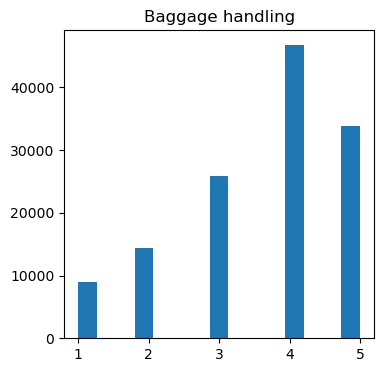

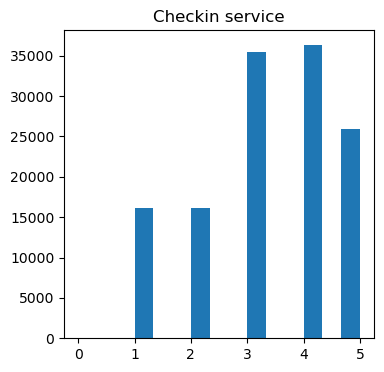

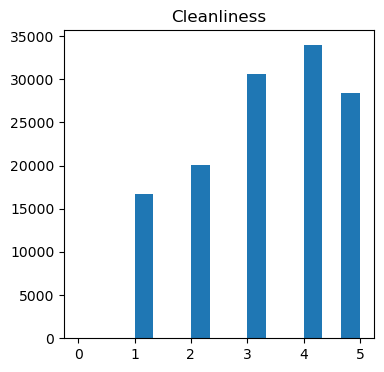

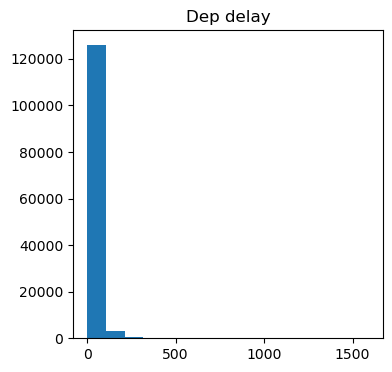

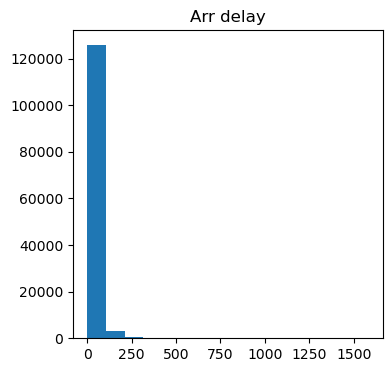

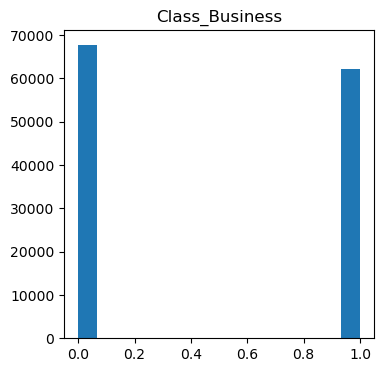

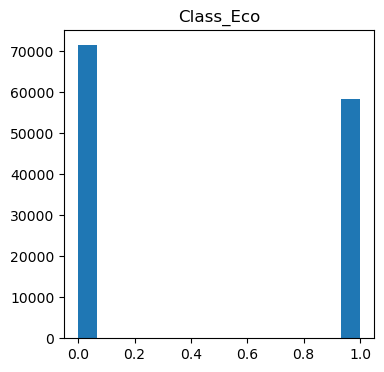

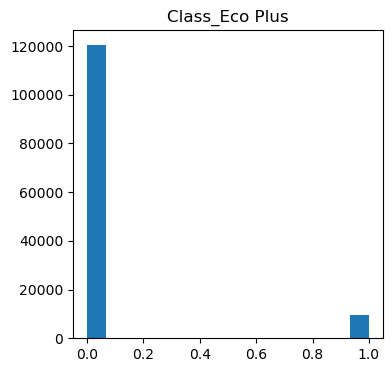

In [16]:
def get_numeric_hist(df, num):
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    for i in range(len(num_cols)):
        plt.figure(figsize=(4, 4))
        plt.hist(df[num_cols[i]], bins=15)
        plt.title(num[i])
        plt.show()
get_numeric_hist(data, num_cols)

### Корреляционный анализ

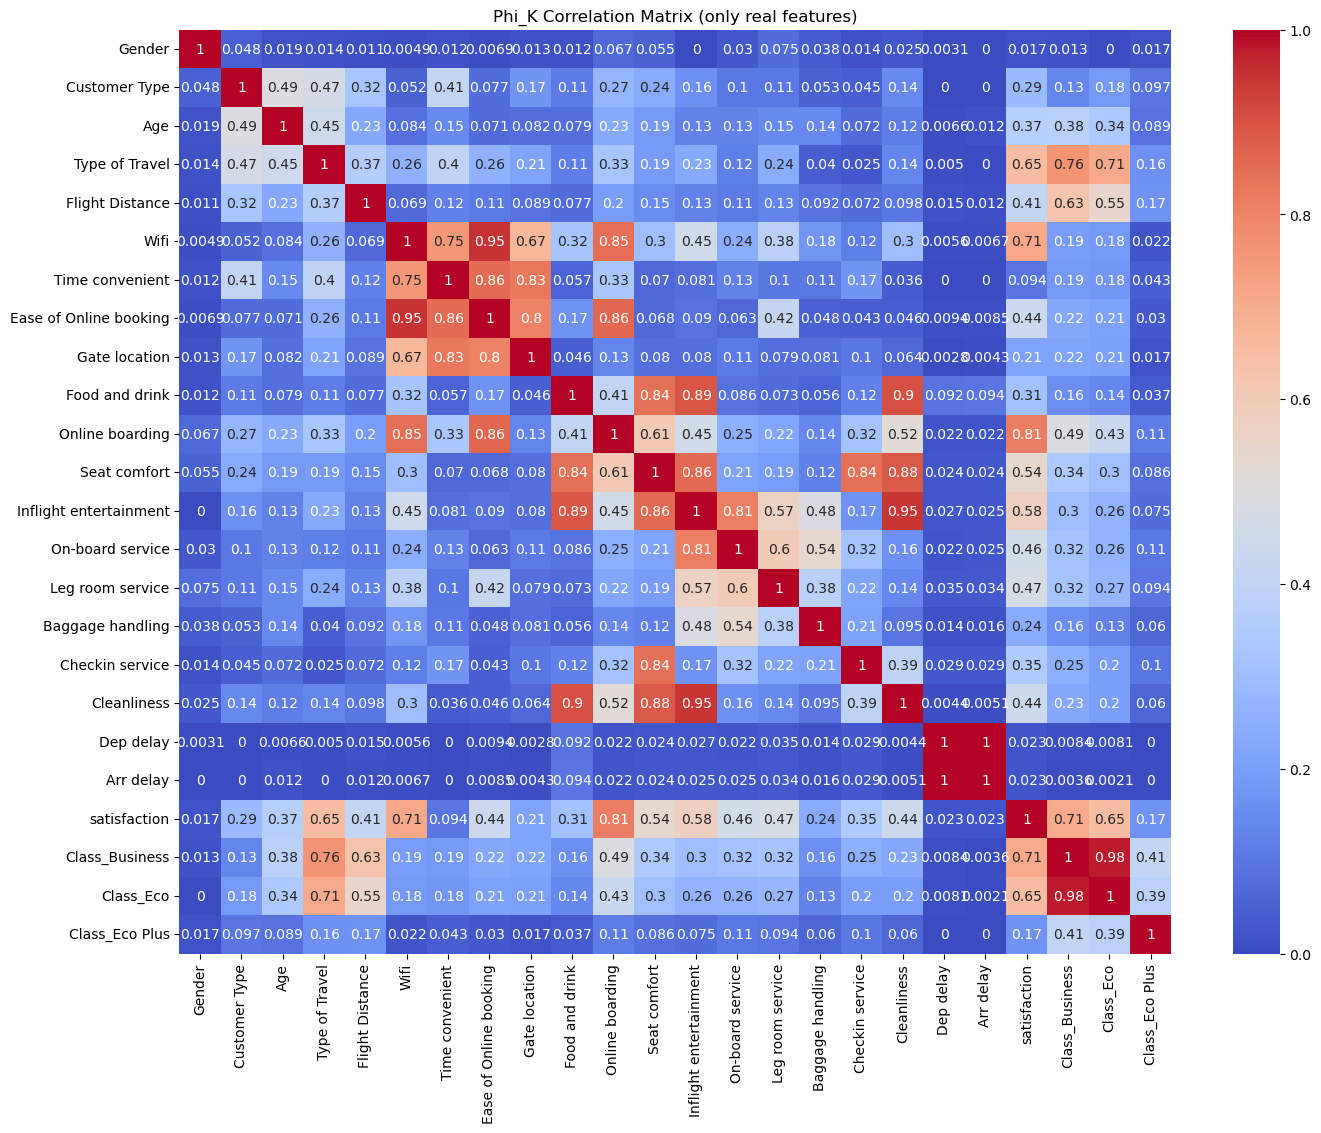

In [17]:
corr = data.phik_matrix(interval_cols=num_cols)
plt.figure(figsize=(16,12))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix (only real features)')
plt.show()

**В матрице много признаков, сильно коррелирующих друг с другом**

Я отберу несколько из них по парам, оставив только один для обучающей выборки:
- Dep delay - Arr delay (оставлю Arr delay)
- Online boarding - Ease of online Booking (оставлю Online boarding)
- Cleanliness - Inflight entertainment (оставлю Inflight entertainment)


In [18]:
def correlation(column_x, column_y):
    return round((((column_x - column_x.mean()) * (column_y - column_y.mean())).sum())\
                 /(((column_x - column_x.mean())**2).sum()\
                   * ((column_y - column_y.mean())**2).sum())**0.5, 2)

In [19]:
temp = {}
for i in data.drop(columns='satisfaction').columns:
    if pd.api.types.is_numeric_dtype(data[i]):
        temp[i] = correlation(data[i], data['satisfaction'])
temp = sorted(temp.items(), key = lambda item: abs(item[1]), reverse=True)
for i, j in temp:
    print(f'{i:10} : {j}')

Online boarding : 0.5
Class_Business : 0.5
Type of Travel : 0.45
Class_Eco  : -0.45
Inflight entertainment : 0.4
Seat comfort : 0.35
On-board service : 0.32
Leg room service : 0.31
Cleanliness : 0.31
Flight Distance : 0.3
Wifi       : 0.28
Baggage handling : 0.25
Checkin service : 0.24
Food and drink : 0.21
Customer Type : -0.19
Ease of Online booking : 0.17
Age        : 0.13
Class_Eco Plus : -0.11
Arr delay  : -0.06
Time convenient : -0.05
Dep delay  : -0.05
Gender     : -0.01
Gate location : -0.0


**Также отбросим факторы, которые особо не влияют на финальный результат(<0.1 по модулю)**

In [20]:
to_delete = ['Dep delay', 'Ease of Online booking', 'Cleanliness', 'Gate location', 'Gender', 'Time convenient']
ord_cols = list(set(ord_cols) - set(to_delete))
numeric = list(set(numeric) - set(to_delete))
ord_cols

['Online boarding',
 'Leg room service',
 'Inflight entertainment',
 'Baggage handling',
 'Wifi',
 'Seat comfort',
 'On-board service',
 'Checkin service',
 'Food and drink']

In [21]:
numeric

['Arr delay', 'Flight Distance', 'Age']

## Обучение модели логистической регрессии

In [22]:
def learn_model(data, ord_cols, to_drop, numeric_cols):
    data = data.drop(columns=to_drop)
    X, y = data.drop(columns='satisfaction'), data['satisfaction']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=RANDOM_STATE)
    #заменяем значения NaN на медианные, чтобы Scaler не рушился на данных
    medians = X_train[ord_cols].median()
    X_train[ord_cols] = X_train[ord_cols].fillna(medians)
    X_test[ord_cols] = X_test[ord_cols].fillna(medians)    
    X_val[ord_cols] = X_val[ord_cols].fillna(medians)
    #нормализуем данные для каждой выборки
    to_norm = ord_cols + numeric_cols
    scaler = StandardScaler()
    X_train[to_norm] = scaler.fit_transform(X_train[to_norm])
    X_val[to_norm] = scaler.transform(X_val[to_norm])
    X_test[to_norm] = scaler.transform(X_test[to_norm])
    
    model = LogisticRegression()
    model.fit(X_train, y_train)

    return model, X_train, X_test, X_val, y_train, y_test, y_val

In [23]:
model, X_train, X_test, X_val, y_train, y_test,\
y_val = learn_model(data_new, ord_cols, to_delete, numeric)

In [24]:
y_val_pred = model.predict(X_val)
y_val_proba = model.predict_proba(X_val)[:,1]

Text(0.5, 1.0, 'Матрица ошибок')

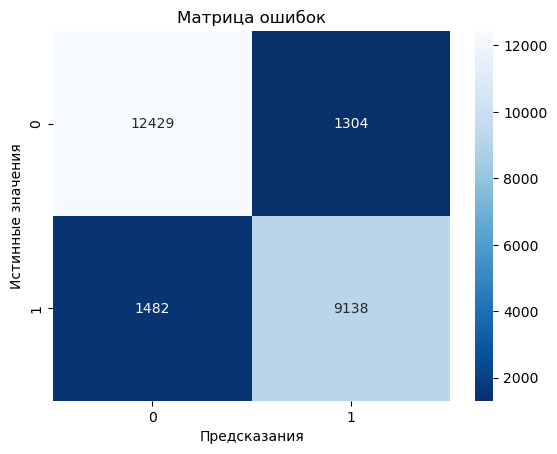

In [25]:
cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot= True, fmt= 'd', cmap= 'Blues_r')
plt.ylabel('Истинные значения')
plt.xlabel('Предсказания')
plt.title('Матрица ошибок')

In [26]:
acc = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
F1 = 2 * precision * recall / (precision + recall + 1e-6)
print('Accuracy =', round(acc, 2))
print('Recall =', round(recall, 2))
print('Precision =', round(precision, 2))
print('F1 score =', round(F1, 2))

Accuracy = 0.89
Recall = 0.86
Precision = 0.88
F1 score = 0.87


In [27]:
for THRESHOLD in np.arange(0.7,0.99,0.01):
        preds = np.where(y_val_proba > THRESHOLD, 1, 0)
        precision_res = precision_score(y_val, preds, zero_division=1)
        acc_res = accuracy_score(y_val, preds)
        print('Порог', round(THRESHOLD, 2), 'значение Precision:', round(precision_res, 2), 'значение Accuracy:', round(acc_res, 2))

Порог 0.7 значение Precision: 0.93 значение Accuracy: 0.88
Порог 0.71 значение Precision: 0.93 значение Accuracy: 0.88
Порог 0.72 значение Precision: 0.93 значение Accuracy: 0.87
Порог 0.73 значение Precision: 0.94 значение Accuracy: 0.87
Порог 0.74 значение Precision: 0.94 значение Accuracy: 0.87
Порог 0.75 значение Precision: 0.94 значение Accuracy: 0.87
Порог 0.76 значение Precision: 0.94 значение Accuracy: 0.86
Порог 0.77 значение Precision: 0.95 значение Accuracy: 0.86
Порог 0.78 значение Precision: 0.95 значение Accuracy: 0.86
Порог 0.79 значение Precision: 0.95 значение Accuracy: 0.86
Порог 0.8 значение Precision: 0.95 значение Accuracy: 0.85
Порог 0.81 значение Precision: 0.95 значение Accuracy: 0.85
Порог 0.82 значение Precision: 0.96 значение Accuracy: 0.85
Порог 0.83 значение Precision: 0.96 значение Accuracy: 0.84
Порог 0.84 значение Precision: 0.96 значение Accuracy: 0.84
Порог 0.85 значение Precision: 0.97 значение Accuracy: 0.84
Порог 0.86 значение Precision: 0.97 значен

In [28]:
precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_proba)
f1_scores = 2 * precisions * recalls / (precisions + recalls + 1e-6)

best_idx = np.argmax(f1_scores)
best_thr = thresholds[best_idx]

print("Лучший порог:", best_thr)
print("F1:", f1_scores[best_idx])

Лучший порог: 0.46621729128136374
F1: 0.8689210778257908


In [29]:
best_thr_pres = 0.97

In [30]:
y_val_pred_2 = (y_val_proba >= best_thr).astype(int)

Text(0.5, 1.0, 'Матрица ошибок')

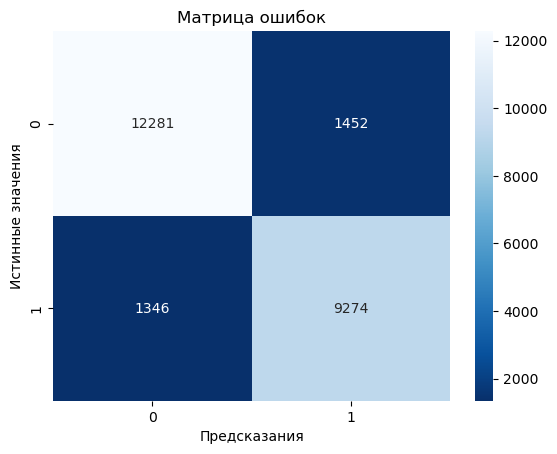

In [31]:
cm2 = confusion_matrix(y_val, y_val_pred_2)
sns.heatmap(cm2, annot= True, fmt= 'd', cmap= 'Blues_r')
plt.ylabel('Истинные значения')
plt.xlabel('Предсказания')
plt.title('Матрица ошибок')

In [32]:
acc_2 = accuracy_score(y_val, y_val_pred_2)
precision_2 = precision_score(y_val, y_val_pred_2)
recall_2 = recall_score(y_val, y_val_pred_2)
F1_2 = 2 * precision_2 * recall_2 / (precision_2 + recall_2 + 1e-6)
print('Accuracy =', round(acc_2, 2))
print('Recall =', round(recall_2, 2))
print('Precision =', round(precision_2, 2))
print('F1 score =', round(F1_2, 2))

Accuracy = 0.89
Recall = 0.87
Precision = 0.86
F1 score = 0.87


**Заметим, что выбранное значение границы является оптимальным и почти одинаково по точности с изначальным**

In [33]:
y_val_pred_3 = (y_val_proba >= best_thr_pres).astype(int)

Text(0.5, 1.0, 'Матрица ошибок')

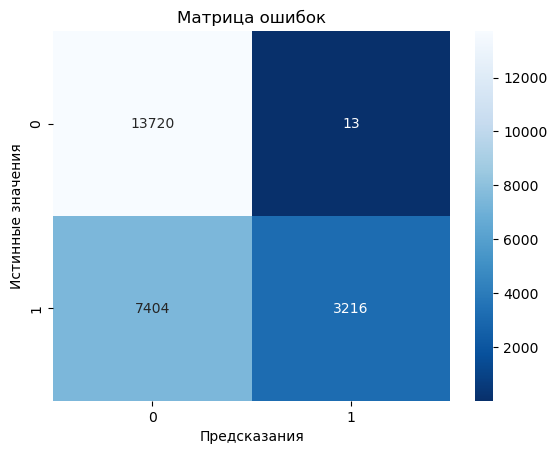

In [34]:
cm4 = confusion_matrix(y_val, y_val_pred_3)
sns.heatmap(cm4, annot= True, fmt= 'd', cmap= 'Blues_r')
plt.ylabel('Истинные значения')
plt.xlabel('Предсказания')
plt.title('Матрица ошибок')

In [35]:
acc_3 = accuracy_score(y_val, y_val_pred_3)
precision_3 = precision_score(y_val, y_val_pred_3)
recall_3 = recall_score(y_val, y_val_pred_3)
F1_3 = 2 * precision_3 * recall_3 / (precision_3 + recall_3 + 1e-6)
print('Accuracy =', round(acc_3, 2))
print('Recall =', round(recall_3, 2))
print('Precision =', round(precision_3, 2))
print('F1 score =', round(F1_3, 2))

Accuracy = 0.7
Recall = 0.3
Precision = 1.0
F1 score = 0.46


**Видно, что можно, например, максимизировать показатель precision, но при этом очень сильно ухудшится точность всей модели, а также будет много FN значений**

### Тестовая выборка

Text(0.5, 1.0, 'Матрица ошибок')

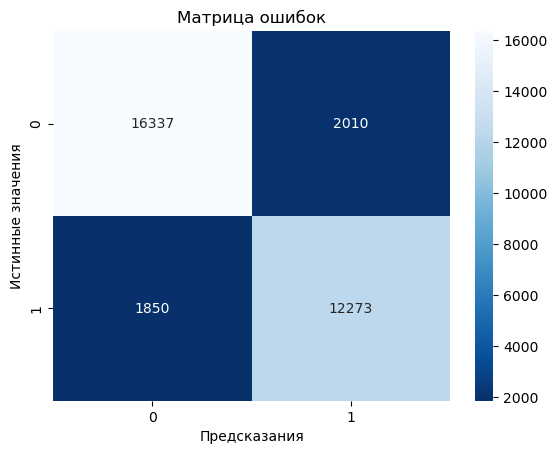

In [36]:
y_test_proba = model.predict_proba(X_test)[:,1]
y_test_pred = (y_test_proba >= best_thr).astype(int)
cm3 = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm3, annot= True, fmt= 'd', cmap= 'Blues_r')
plt.ylabel('Истинные значения')
plt.xlabel('Предсказания')
plt.title('Матрица ошибок')

In [37]:
acc_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
F1_test = 2 * precision_test * recall_test / (precision_test + recall_test + 1e-6)
print('Accuracy =', round(acc_test, 2))
print('Recall =', round(recall_test, 2))
print('Precision =', round(precision_test, 2))
print('F1 score =', round(F1_test, 2))

Accuracy = 0.88
Recall = 0.87
Precision = 0.86
F1 score = 0.86


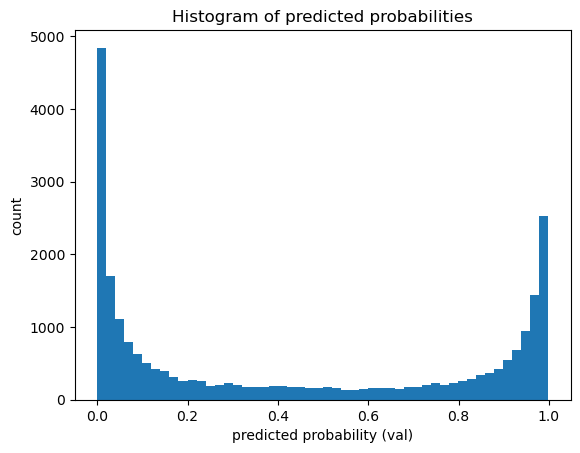

In [38]:
plt.hist(y_val_proba, bins=50)
plt.xlabel("predicted probability (val)"); plt.ylabel("count"); plt.title("Histogram of predicted probabilities")
plt.show()

**Мы видим хорошее определение объектов моделью**

## Вывод

**Задача. Бинарная классификация удовлетворенности пассажиров авиалинии по табличным признакам.

Модель. Logistic Regression с предобработкой: StandardScaler для числовых, One-Hot Encoding для категориальных, всё в sklearn-pipeline.

Качество на тесте.
Accuracy ≈ 0.88, Precision ≈ 0.86, Recall ≈ 0.87, F1 ≈ 0.86. Значения стабильны для текущего разбиения; при пересемплинге возможны колебания в пределах нескольких сотых.

Вывод. Модель даёт адекватный baseline: интерпретируемая, быстрая, и не переучивается на очевидных признаках. Для production-уровня не хватает калибровки вероятностей и анализа компромисса precision/recall под бизнес-цели.